In [1]:
import pandas as pd
import numpy as np
from dscost.pipeline import utils
from dsfunction.resources import load_map
from collections import defaultdict, Counter
import json
import matplotlib.pyplot as plt
import seaborn as sns
from dsfunction.resources import load_map
import scipy.sparse as sparse
from dateutil.relativedelta import relativedelta
from datetime import datetime
from pyspark.sql.types import *
import pyspark.sql.functions as fn
from google.cloud import bigquery
from dateutil import relativedelta
from sklearn.feature_extraction import DictVectorizer
from random import sample
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, auc

In [2]:
sql = SQLContext(sc)
inpath = 'lumiata-internal-6f5a.dwight_multiplan.tbl_202011_CNXNonPar_FinalExtract_V2'
LDM = sql.read.format('bigquery').option('table', inpath).load()
df = pd.read_csv('gs://lumi-dev/users/rohun/multiplan')

/usr/local/lib/python3.6/site-packages/aiohttp-4.0.0a1-py3.6-linux-x86_64.egg/aiohttp/client.py:977: RuntimeWarning: coroutine 'noop' was never awaited
  self._resp.release()
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,10,11,16,34,36,37,38,39,40,41,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(924755, 57)

In [4]:
df.head()

,ClaimID,PriorClaimID,ClaimType,MemberDOB,MemberSex,ProductCode,BillType,ServiceFrom,ServiceTo,AdmitDate,...,MOD2,MOD3,MOD4,LineStartDate,LineEndDate,LineUnits,LineNPI,LineCharges,LineNonCovCharges,CLAIM_PAR_SCORE
0,190121161220,NaN,U,1992-11-02 00:00:00.0000000,F,NaN,131,2018-12-24,2018-12-31,2018-12-24,...,NaN,NaN,NaN,2018-12-24 00:00:00.0000000,2018-12-24 00:00:00.0000000,1.0,NaN,229.0,0.0,-53.0
1,190121161220,NaN,U,1992-11-02 00:00:00.0000000,F,NaN,131,2018-12-24,2018-12-31,2018-12-24,...,NaN,NaN,NaN,2018-12-31 00:00:00.0000000,2018-12-31 00:00:00.0000000,1.0,NaN,229.0,0.0,-53.0
2,190121161220,NaN,U,1992-11-02 00:00:00.0000000,F,NaN,131,2018-12-24,2018-12-31,2018-12-24,...,NaN,NaN,NaN,2018-12-27 00:00:00.0000000,2018-12-27 00:00:00.0000000,1.0,NaN,229.0,0.0,-53.0
3,190121161220,NaN,U,1992-11-02 00:00:00.0000000,F,NaN,131,2018-12-24,2018-12-31,2018-12-24,...,NaN,NaN,NaN,2018-12-24 00:00:00.0000000,2018-12-24 00:00:00.0000000,3.0,NaN,687.0,0.0,-53.0
4,190121161220,NaN,U,1992-11-02 00:00:00.0000000,F,NaN,131,2018-12-24,2018-12-31,2018-12-24,...,NaN,NaN,NaN,2018-12-28 00:00:00.0000000,2018-12-28 00:00:00.0000000,3.0,NaN,687.0,0.0,-53.0


In [5]:
df.columns

Index(['ClaimID', 'PriorClaimID', 'ClaimType', 'MemberDOB', 'MemberSex',
       'ProductCode', 'BillType', 'ServiceFrom', 'ServiceTo', 'AdmitDate',
       'AdmitType', 'AdmitSource', 'DischargeStatus', 'ProviderID',
       'ProviderOrg', 'ProviderLName', 'ProviderFName', 'ProviderTIN',
       'ProviderNP', 'ProviderState', 'HdrCharges', 'ASOFlag',
       'ContractedFlag', 'PrimaryFlag', 'DRGCode', 'DRGVersion',
       'PrincipalDiag1', 'AdmittingDiag', 'Diag2', 'Diag3', 'Diag4', 'Diag5',
       'Diag6', 'Diag7', 'ICDProc1Princ', 'ICDProc1Date', 'ICDProc2',
       'ICDProc2Date', 'ICDProc3', 'ICDProc3Date', 'ICDProc4', 'ICDProc4Date',
       'LineNumber', 'LineRevCode', 'LinePOS', 'LineProcCode', 'MOD1', 'MOD2',
       'MOD3', 'MOD4', 'LineStartDate', 'LineEndDate', 'LineUnits', 'LineNPI',
       'LineCharges', 'LineNonCovCharges', 'CLAIM_PAR_SCORE'],
      dtype='object')

In [6]:
single_columns = ['PriorClaimID',
 'ClaimType',
 'ProductCode',
 'ProviderID',
 'ProviderNP',
 'ASOFlag',
 'ContractedFlag',
 'PrimaryFlag',
 'DRGVersion',
 'LinePOS',
 'LineNPI']
df = df.drop(columns=single_columns)

In [7]:
df['bday'] = pd.to_datetime(df['MemberDOB'].str[:10], errors='coerce')
now = pd.Timestamp('now')
df['bday'] = pd.to_datetime(df['bday'], format='%m%d%y')    # 1
df['age'] = now.year - df['bday'].dt.year
df['CLAIM_PAR_SCORE'] = pd.to_numeric(df['CLAIM_PAR_SCORE'], errors='coerce')
df['LineUnits'] = pd.to_numeric(df['LineUnits'], errors='coerce')
df['LineNumber'] = pd.to_numeric(df['LineNumber'], errors='coerce')
df['LineCharges'] = pd.to_numeric(df['LineCharges'], errors='coerce')
df['LineNonCovCharges'] = pd.to_numeric(df['LineNonCovCharges'], errors='coerce')
df['HdrCharges'] = pd.to_numeric(df['HdrCharges'], errors='coerce')

In [8]:
need_cols = ['ClaimID', 'MemberSex', 'age','PrincipalDiag1','AdmittingDiag', 'Diag2', 'Diag3', 'Diag4',
'LineRevCode','LineProcCode', 'LineNumber',
'CLAIM_PAR_SCORE']

In [9]:
df = df[need_cols]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924755 entries, 0 to 924754
Data columns (total 12 columns):
ClaimID            924755 non-null int64
MemberSex          924755 non-null object
age                924755 non-null int64
PrincipalDiag1     920395 non-null object
AdmittingDiag      920395 non-null object
Diag2              561097 non-null object
Diag3              357250 non-null object
Diag4              217882 non-null object
LineRevCode        924755 non-null int64
LineProcCode       924714 non-null object
LineNumber         924755 non-null int64
CLAIM_PAR_SCORE    918108 non-null float64
dtypes: float64(1), int64(4), object(7)
memory usage: 84.7+ MB


In [11]:
df = df[df['age'] <= 110]

In [12]:
dx_claim = defaultdict(dict)

#for col in ['MemberSex', 'age']:
d = dict(zip(df['ClaimID'].values, df['MemberSex'].values))
for cl in d:
    dx_claim[cl]['gender_'+d[cl]] = 1

d = dict(zip(df['ClaimID'].values, df['age'].values))
for cl in d:
    dx_claim[cl]['age'] = d[cl]    

d = dict(zip(df['ClaimID'].values, df['LineNumber'].values))
for cl in d:
    dx_claim[cl]['LineNumber'] = d[cl]      

for col in ['AdmittingDiag', 'Diag2', 'Diag3', 'Diag4']:
    print(col)
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            dx_claim[cl]['diag_'+d[cl]] = 1            

AdmittingDiag
Diag2
Diag3
Diag4


In [13]:
#train_keys = sample(list(dx_claim), 200000)
train_keys = list(dx_claim)
train_dic = {k:dx_claim[k] for k in train_keys}
test_keys = [k for k in dx_claim if k not in train_dic]
print(len(train_keys), len(test_keys))

303467 0


In [14]:
train_dx = [train_dic[i] for i in train_keys]
#test_dx = [dx_claim[i] for i in test_keys]
dv1 = DictVectorizer()
train_mat = dv1.fit_transform(train_dx)
#test_mat = dv1.transform(test_dx)
train_mat.shape

(303467, 9057)

In [15]:
proc_claim = defaultdict(dict)
for col in ['LineProcCode']:
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            proc_claim[cl]['line_proc_'+d[cl]] = 1

In [16]:
train_proc_lst = [proc_claim[i] for i in train_keys]
#test_proc_lst = [proc_claim[i] for i in test_keys]
dv2 = DictVectorizer()
train_proc_mat = dv2.fit_transform(train_proc_lst)
#test_proc_mat = dv2.transform(test_proc_lst)
train_proc_mat.shape

(303467, 3247)

In [17]:
rev_claim = defaultdict(dict)
for col in ['LineRevCode']:
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            rev_claim[cl]['line_rev_'+d[cl]] = 1

In [18]:
df['LineRevCode']

0         942
1         942
2         904
3         915
4         915
5         915
6         915
7         915
8         942
9         904
10        904
11        942
12        914
13        904
14        904
15        942
16        300
17        450
18        300
19        762
20        914
21        914
22        450
23        636
24        450
25        918
26        914
27        450
28        300
29        450
         ... 
924725    981
924726    981
924727    301
924728    900
924729    900
924730    900
924731    900
924732    900
924733    900
924734    900
924735    900
924736    900
924737    900
924738    900
924739    900
924740    900
924741    258
924742    901
924743    730
924744    324
924745    305
924746    450
924747    450
924748    730
924749    270
924750    300
924751    300
924752    300
924753      4
924754      4
Name: LineRevCode, Length: 924241, dtype: int64

In [19]:
train_rev_lst = [rev_claim[i] for i in train_keys]
#test_rev_lst = [rev_claim[i] for i in test_keys]
dv3 = DictVectorizer()
train_rev_mat = dv3.fit_transform(train_rev_lst)
#test_rev_mat = dv3.transform(test_rev_lst)
train_rev_mat.shape#, test_rev_mat.shape

(303467, 0)

In [20]:
train_mat = sparse.hstack((train_mat, train_proc_mat), format='csr')
#test_mat = sparse.hstack((test_mat, test_proc_mat), format='csr')
train_mat.shape #, test_mat.shape

(303467, 12304)

In [21]:
train_mat = sparse.hstack((train_mat, train_rev_mat), format='csr')
#test_mat = sparse.hstack((test_mat, test_rev_mat), format='csr')
train_mat.shape #, test_mat.shape

(303467, 12304)

In [22]:
df_grouped = pd.DataFrame(df.groupby('ClaimID')['CLAIM_PAR_SCORE'].mean()).reset_index()
target = dict(zip(df_grouped['ClaimID'].values, df_grouped['CLAIM_PAR_SCORE'].values))

In [23]:
train_target = [ target[i] for i in train_keys]
#test_target = [ target[i] for i in test_keys]

In [24]:
len(train_keys)

303467

In [29]:
from sklearn.ensemble import IsolationForest
clf1 = IsolationForest(behaviour='new')
clf1.fit(train_mat)
y_train_scores = clf1.decision_function(train_mat)
y_train_labels = clf1.predict(train_mat)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [30]:
data = {'claim_id' : train_keys,
        'anomaly_score':y_train_scores, 
        'anomaly_label':y_train_labels,
        'par_score':train_target} 
  
# Create DataFrame 
df = pd.DataFrame(data) 

In [31]:
df.columns

Index(['claim_id', 'anomaly_score', 'anomaly_label', 'par_score'], dtype='object')

In [32]:
#df.to_csv('gs://lumi-dev/users/dwight/multiplan/upload_bigquery/dwight_score_table.csv')

In [33]:
#dff = pd.read_csv('gs://lumi-dev/users/rohun/multiplan')

In [34]:
#df['claim_id'] = df['claim_id'].astype(str)

In [35]:
#com_table = dff.merge(df.drop(['par_score'], axis=1), left_on='ClaimID', right_on='claim_id')

In [36]:
#df.shape

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303467 entries, 0 to 303466
Data columns (total 4 columns):
claim_id         303467 non-null int64
anomaly_score    303467 non-null float64
anomaly_label    303467 non-null int64
par_score        301878 non-null float64
dtypes: float64(2), int64(2)
memory usage: 9.3 MB


In [38]:
#com_table.to_csv('gs://lumi-dev/users/dwight/multiplan/upload_bigquery/dwight_score_table.csv')

In [39]:
df[(df['anomaly_label'] < 0) & (df['par_score']<0)]['claim_id'].nunique()

4430

In [40]:
#com_table.drop(['AdmitSource'],axis=1).to_csv('gs://lumi-dev/users/dwight/multiplan/upload_bigquery/dwight_score_table.csv')

In [41]:
#df.to_csv('gs://lumi-dev/users/dwight/multiplan/upload_bigquery/dwight_score_table.csv')

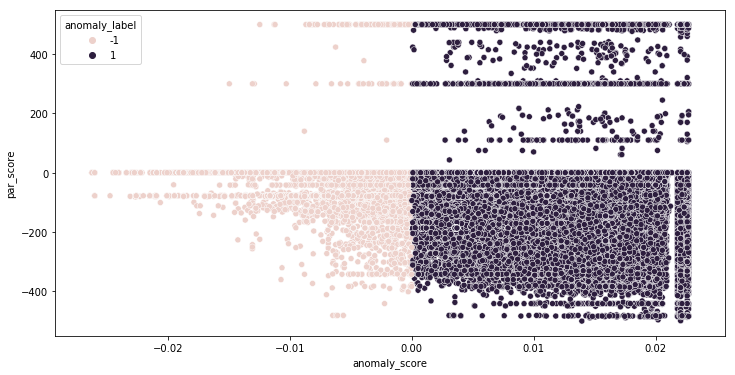

In [42]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='anomaly_score', y='par_score', data=df, hue='anomaly_label')
plt.show()

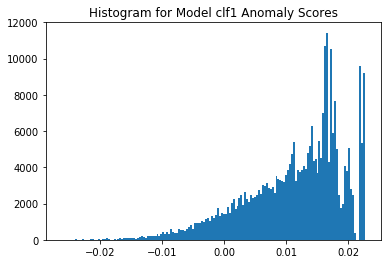

In [43]:
plt.hist(df['anomaly_score'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()

Text(0, 0.5, 'par score')

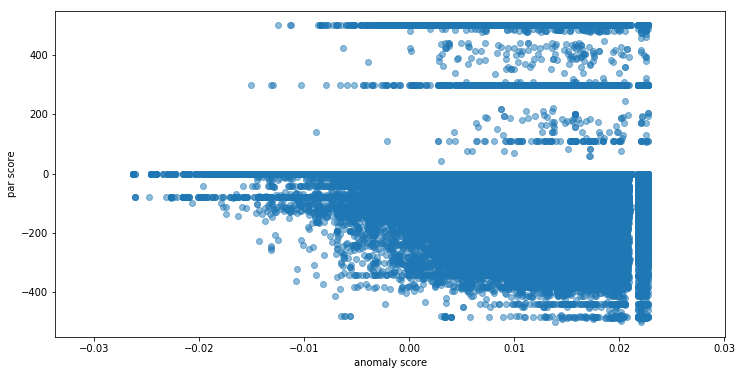

In [44]:
plt.figure(figsize=(12,6))
plt.scatter(df['anomaly_score'], df['par_score'], alpha=0.5)
plt.xlabel('anomaly score')
plt.ylabel('par score')

In [45]:
par_median = df['par_score'].median()
anomaly_median = df['anomaly_score'].median()
df['par_score_split'] = np.where(df['par_score'] <= par_median,'par_low', 'par_high')
df['anomaly_score_split'] = np.where(df['anomaly_score'] <= par_median,'anomaly_low', 'anomaly_high')

In [46]:
par_median, anomaly_median

(0.0, 0.013186549668239178)

In [47]:
df.groupby(['par_score_split', 'anomaly_score_split']).size()

par_score_split  anomaly_score_split
par_high         anomaly_high             8136
                 anomaly_low               322
par_low          anomaly_high           264976
                 anomaly_low             30033
dtype: int64

In [48]:
df[(df['anomaly_score_split'] == 'anomaly_low') & (df['par_score_split'] == 'par_low')]['claim_id'].nunique()

30033

In [49]:
df_neg = df[df['par_score'] < 0].copy()
df_pox = df[df['par_score'] > 0].copy()
df_zero = df[df['par_score'] == 0].copy()

In [50]:
df_neg.shape

(92082, 6)

In [51]:
df_zero.shape

(202927, 6)

In [52]:
df_pox.shape

(6869, 6)

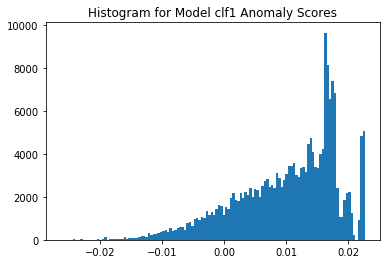

In [53]:
plt.hist(df_zero['anomaly_score'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()

Text(0, 0.5, 'par score')

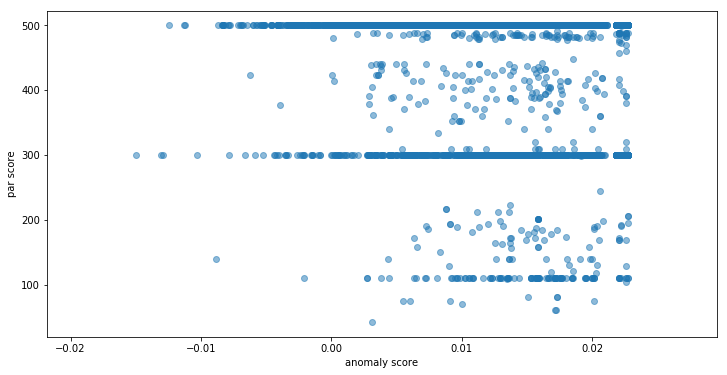

In [54]:
plt.figure(figsize=(12,6))
plt.scatter(df_pox['anomaly_score'], df_pox['par_score'], alpha=0.5)
plt.xlabel('anomaly score')
plt.ylabel('par score')

Text(0, 0.5, 'par score')

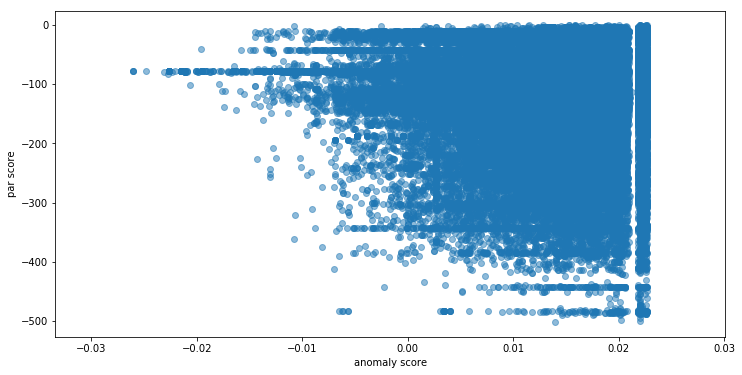

In [55]:
plt.figure(figsize=(12,6))
plt.scatter(df_neg['anomaly_score'], df_neg['par_score'], alpha=0.5)
plt.xlabel('anomaly score')
plt.ylabel('par score')

In [56]:
# positive section

In [57]:
df_pox['par_score_group'] = np.where(df_pox['par_score'] > 400, '>400', np.where(df_pox['par_score']> 200, '200-400', '<200'))

In [58]:
qs = df_pox.groupby("par_score_group")["anomaly_score"].quantile([0.25,0.75])
qs = qs.unstack().reset_index()
qs.columns = ["par_score_group", "q1", "q3"]
df_pox_m = pd.merge(df_pox, qs, on="par_score_group", how="left")

In [59]:
def outlier_check(row):
    if row['anomaly_score'] < row['q1'] :
        return 'True'
    else:
        return 'False'

In [60]:
df_pox_m["outlier"] = df_pox_m.apply(outlier_check,axis=1)

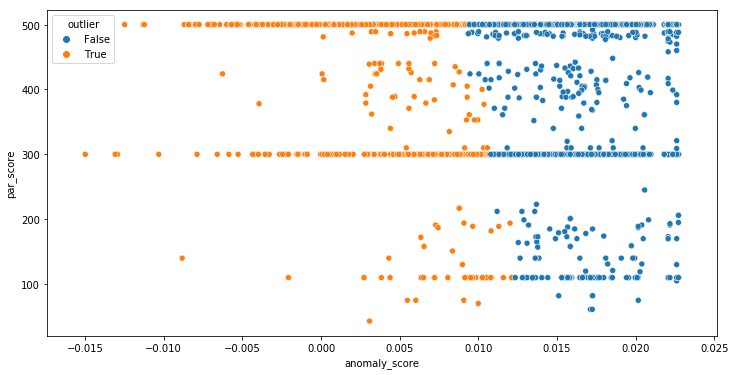

In [61]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='anomaly_score', y='par_score', data=df_pox_m, hue='outlier')

In [63]:
lower_fence = 2.5*df_zero['anomaly_score'].quantile(0.25) - 1.5*df_zero['anomaly_score'].quantile(0.75) 
lower_fence = df_zero['anomaly_score'].quantile(0.25) 
df_zero['outlier'] = np.where(df_zero['anomaly_score'] < lower_fence, 'True', 'False')

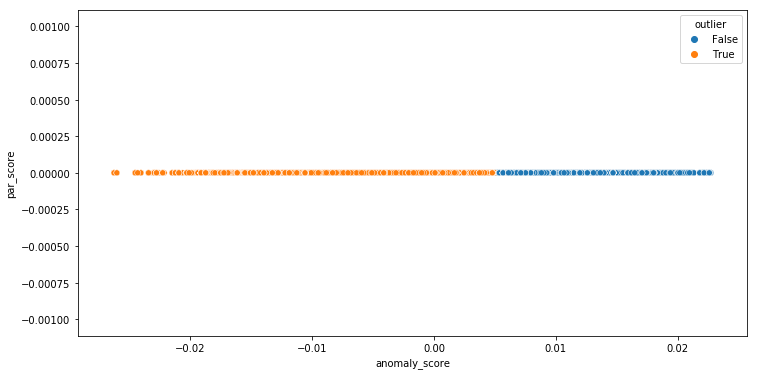

In [64]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='anomaly_score', y='par_score', data=df_zero, hue='outlier')

In [65]:
df_zero

,claim_id,anomaly_score,anomaly_label,par_score,par_score_split,anomaly_score_split,outlier
6,190213019424,0.017682,1,0.0,par_low,anomaly_high,False
9,200514159553,0.020815,1,0.0,par_low,anomaly_high,False
10,190907021425,0.016346,1,0.0,par_low,anomaly_high,False
11,181023023975,0.016229,1,0.0,par_low,anomaly_high,False
14,190521024586,0.016731,1,0.0,par_low,anomaly_high,False
15,200815027313,0.006349,1,0.0,par_low,anomaly_high,False
16,200324048731,0.012225,1,0.0,par_low,anomaly_high,False
17,200427146538,0.009751,1,0.0,par_low,anomaly_high,False
18,200403034949,0.020815,1,0.0,par_low,anomaly_high,False
19,200316012026,0.022601,1,0.0,par_low,anomaly_high,False


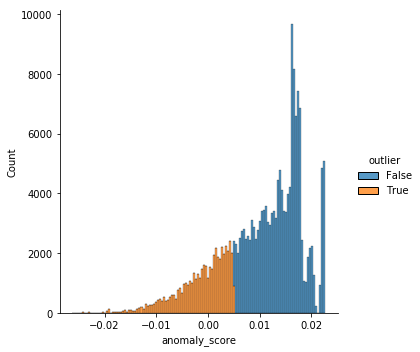

In [66]:
sns.displot(data=df_zero, x="anomaly_score", hue="outlier", multiple="stack")

In [67]:
# negative par score

In [68]:
df_neg['par_score_group'] = pd.qcut(df_neg['par_score'] ,10)
#df['par_score_group_rnk'] = pd.qcut(df['par_score'].rank(method='first') ,10)

In [69]:
qs = df_neg.groupby("par_score_group")["anomaly_score"].quantile([0.25,0.75])
qs = qs.unstack().reset_index()
qs.columns = ["par_score_group", "q1", "q3"]
df_neg_m = pd.merge(df_neg, qs, on="par_score_group", how="left")

In [70]:
df_neg_m["outlier"] = df_neg_m.apply(outlier_check,axis=1)

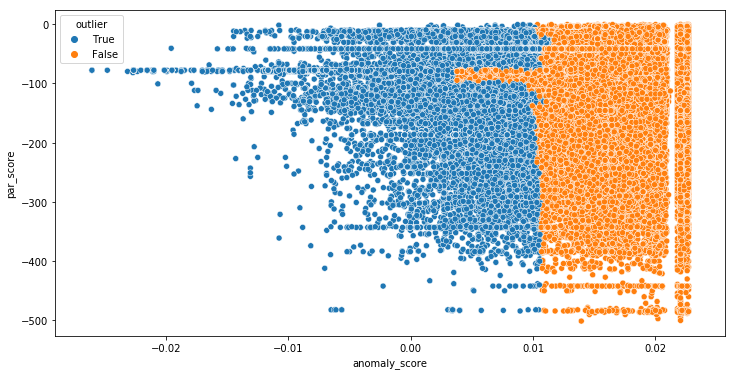

In [71]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='anomaly_score', y='par_score', data=df_neg_m, hue='outlier')

In [72]:
df_zero[df_zero['outlier'] == 'True'].shape

(50710, 7)

In [73]:
df_neg_m[df_neg_m['outlier'] == 'True'].shape

(23004, 10)

In [74]:
df_pox_m[df_pox_m['outlier'] == 'True'].shape

(1717, 10)